In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sensr import calc_sensitive_directions, compl_svd_projector, unprotected_direction
from sensr import normalize_sensitive_directions, sample_perturbation, sample_perturbation

from models import MLP
from training import train_classifier

In [2]:
def plot_decision(model, x, y):
    plot_step = 0.02
    X = x.cpu().numpy()
    Y = y.cpu().numpy()
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    
    xs = np.c_[xx.ravel(), yy.ravel()]
    Z = model(torch.FloatTensor(xs)).detach().cpu().numpy()[:,1]
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:,0], X[:,1], c=Y)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def gen_synth_data(ds_size=6000):
    pr_priv_fav=0.3
    pr_unpriv_fav=1 - pr_priv_fav
    
    n_priv_fav = int((ds_size//2) * pr_priv_fav)
    n_unpriv_fav =int((ds_size//2) * pr_unpriv_fav)
    n_priv_unfav = int((ds_size//2) * (1-pr_priv_fav))
    n_unpriv_unfav = int((ds_size//2) * (1-pr_unpriv_fav))
  
    x_priv_fav = torch.cat([torch.normal(mean=2, std=1, size=(n_priv_fav, 1)), torch.normal(mean=1, std=0.02, size=(n_priv_fav, 1))], dim=1)
    x_unpriv_fav = torch.cat([torch.normal(mean=2, std=1, size=(n_unpriv_fav, 1)), torch.normal(mean=0, std=0.02, size=(n_unpriv_fav, 1))], dim=1)
    
    x_priv_unfav = torch.cat([torch.normal(mean=0, std=1, size=(n_priv_unfav, 1)), torch.normal(mean=1, std=0.02, size=(n_priv_unfav, 1))], dim=1)
    x_unpriv_unfav = torch.cat([torch.normal(mean=0, std=1, size=(n_unpriv_unfav, 1)), torch.normal(mean=0, std=0.02, size=(n_unpriv_unfav, 1))], dim=1)
    
    synth_inputs = torch.cat((x_priv_fav, x_unpriv_fav, x_priv_unfav, x_unpriv_unfav), dim=0)
    synth_labels = torch.cat( (torch.ones(n_priv_fav + n_unpriv_fav), torch.zeros(n_priv_unfav + n_unpriv_unfav)), dim=0)
    synth_metas = torch.cat( (torch.ones(n_priv_fav), torch.zeros(n_unpriv_fav), torch.ones(n_priv_unfav), torch.zeros(n_unpriv_unfav)), dim=0)
    
    return synth_inputs, synth_labels, synth_metas

In [5]:
x, y, s = gen_synth_data()

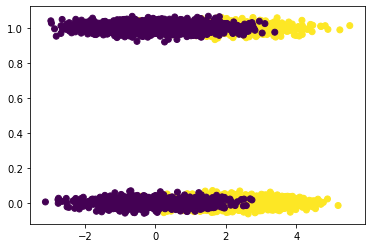

In [6]:
plt.scatter(x[:,0], x[:,1], c=y)

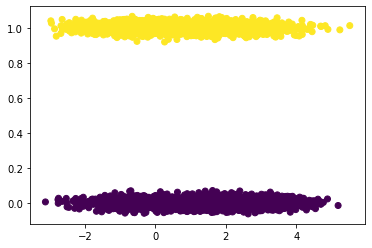

In [7]:
plt.scatter(x[:,0], x[:,1], c=s)

In [8]:
sensitive_directions = calc_sensitive_directions(x.numpy(), s.numpy())
sensitive_directions

array([[-0.20636837, 15.29788413]])

In [9]:
sensitive_directions_ = normalize_sensitive_directions(sensitive_directions.T)
sensitive_directions_

array([[ 1.81946830e-04, -1.34875396e-02],
       [-1.34875396e-02,  9.99818053e-01]])

In [10]:
proj = compl_svd_projector(sensitive_directions)
proj

array([[9.99818053e-01, 1.34875396e-02],
       [1.34875396e-02, 1.81946830e-04]])

In [11]:
# xp = unprotected_direction(x, sensitive_directions_)
xp = torch.matmul(x, torch.FloatTensor(proj))

In [12]:
x.shape, xp.shape

(torch.Size([6000, 2]), torch.Size([6000, 2]))

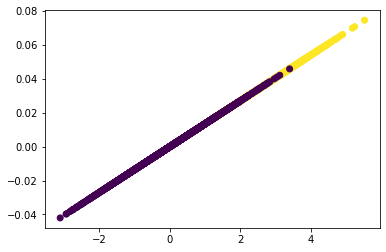

In [13]:
plt.scatter(xp[:,0], xp[:,1], c=y)

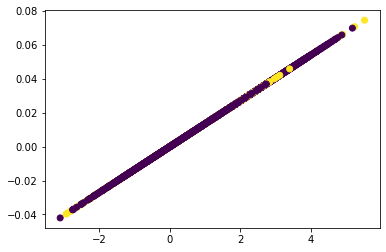

In [14]:
plt.scatter(xp[:,0], xp[:,1], c=s)

In [15]:
batch_size = 128

dataset = TensorDataset(x.float(), y.long(), s.long())
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [16]:
model = MLP(2, [10, 10], 2)

In [17]:
optimizer_clf = optim.Adam(model.parameters(), lr=0.005)
loss_criterion = torch.nn.CrossEntropyLoss()

In [18]:
model = train_classifier(model, optimizer_clf, loader, loss_criterion, 100, "cpu")

Average Clf epoch loss: 0.3132548947283562: 100%|████████████████████████████████████| 100/100 [00:14<00:00,  7.12it/s]

Average Clf batch loss:  0.3166901312324595


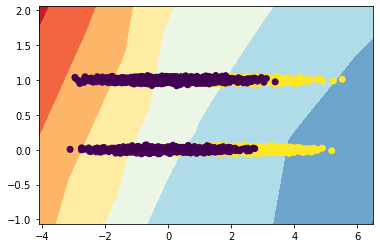

In [19]:
plot_decision(model, x, y)

In [20]:
yh = model(x)
np.mean(yh.detach().numpy().argmax(-1) == y.numpy())

0.8643333333333333

In [21]:
batch_size = 128

dataset = TensorDataset(xp.float(), y.long(), s.long())
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [22]:
modelp = MLP(2, [10, 10], 2)
optimizer_clf = optim.Adam(modelp.parameters(), lr=0.005)
modelp = train_classifier(modelp, optimizer_clf, loader, loss_criterion, 100, "cpu")

Average Clf epoch loss: 0.3538120274848126: 100%|████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]

Average Clf batch loss:  0.3559337597895176


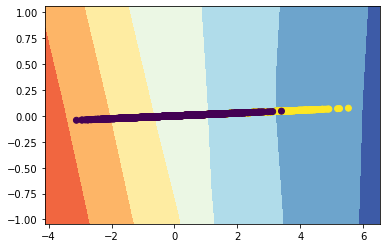

In [23]:
plot_decision(modelp, xp, y)

In [24]:
yh = modelp(xp.float())
np.mean(yh.detach().numpy().argmax(-1) == y.numpy())

0.8396666666666667

In [25]:
xp = sample_perturbation(model, x, y.long(), sensitive_directions, learning_rate=0.1, num_steps=200, regularizer=1e3)
xp_ = (xp - xp.min(0, keepdim=True)[0])/(xp.max(0, keepdim=True)[0]-xp.min(0, keepdim=True)[0])

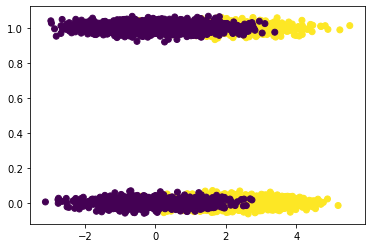

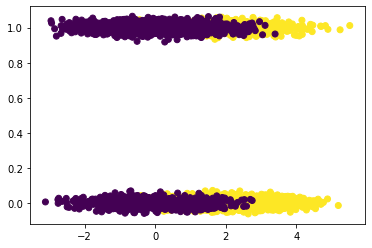

In [26]:
plt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), c=y)
plt.figure()
plt.scatter(xp[:,0].detach().numpy(), xp[:,1].detach().numpy(), c=y)

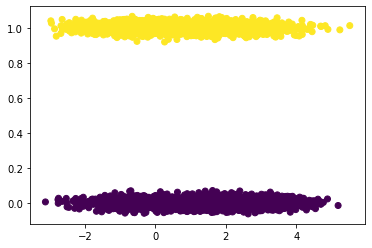

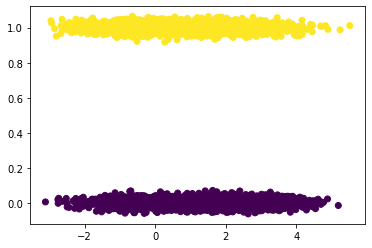

In [27]:
plt.scatter(x[:,0].detach().numpy(), x[:,1].detach().numpy(), c=s)
plt.figure()
plt.scatter(xp[:,0].detach().numpy(), xp[:,1].detach().numpy(), c=s)

In [28]:
batch_size = 128

dataset = TensorDataset(xp_.float(), y.long(), s.long())
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [29]:
modelp = MLP(2, [10, 10], 2)
optimizer_clf = optim.Adam(modelp.parameters(), lr=0.005)
modelp = train_classifier(modelp, optimizer_clf, loader, loss_criterion, 100, "cpu")

Average Clf epoch loss: 0.31767164170742035: 100%|███████████████████████████████████| 100/100 [00:14<00:00,  7.06it/s]

Average Clf batch loss:  0.32070662892879326


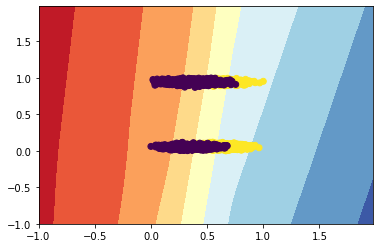

In [34]:
plot_decision(modelp, xp_, y)

In [35]:
yh = modelp(xp_.float())
np.mean(yh.detach().numpy().argmax(-1) == y.numpy())

0.863